In [3]:
pip install -r install.txt

     |████████████████████████████████| 23.6MB 19.9MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Vegetation Index
### *Using NDVI (Normalized Difference Vegetation Index)

To calculate the NDVI, we need Red band and Near-Infrared Band (NIR). Different satellite images assign different numbers for these bands. Sentinel Images have red in 4th band and NIR in the 8th band. The formula for NDVI calculation is:

$$NDVI = \frac{nir - red}{nir + red} $$


We use `rasterio` here to calculate and visualize ndvi. Rasterio document: https://rasterio.readthedocs.io/en/stable/quickstart.html

In [187]:
import rasterio as rio
from rasterio import plot
import numpy as np
from PIL import Image, ImageDraw
import glob
import os
import matplotlib.pyplot as plt
from matplotlib import colors



# The initial release contains only one tile, so lets hardcode its location
# here.  When you have more tiles, you can update this
TILE_X = 7680
TILE_Y = 10240

# The expected value of a Pixel in a mask file indicating that the pixel is
# within that region.  Tuple value, (Red, Green, Blue, Alpha)
IS_IN_MASK_PIXEL_VALUE = (0, 0, 0, 255)

# Tile width / height in pixels

TILE_WIDTH_PX = 512
TILE_HEIGHT_PX = 512

def get_cropped_image_paths(tile_x, tile_y, band, date):
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/cropped/cropped-{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 

def get_timeseries_image_paths(tile_x, tile_y, band, date):
    path = f"./data/sentinel-2a-tile-{tile_x}x-{tile_y}y/timeseries/{tile_x}-{tile_y}-{band}-{date}.png"
    #path = glob.glob(path)
    #path = path[0] # get the first date 
    return path 

def get_band(tile_x, tile_y, date, band, img, cropped = True):
    if cropped == True:
        path = get_cropped_image_paths(tile_x, tile_y, band, date)
    else:
        path = get_time_image_paths(tile_x, tile_y, band, date)
    b = rio.open(path)
    if img!='NDVI': 
        read_type = 1 
        read = b.read(read_type)
        
    else: 
        read_type = None 
        read = b.read(read_type).astype('float64')
    
    get_band = dict()
    get_band['read'] = read; get_band['b'] = b

    return get_band


   

In [188]:
def NDVI(tile_x, tile_y, date, img = 'NDVI'):
    get_red = get_band(tile_x, tile_y, date, band='B04', img = img)
    red = get_red['read']
    b4 = get_red['b']
    
    get_nir = get_band(tile_x, tile_y, date, band='B08', img = img)
    nir = get_nir['read']
    b8 = get_nir['b']
   
    ndvi = np.where((nir+red)==0., 0, (nir-red)/(nir+red))[0]
    
    ndviImage = rio.open(f'./Output/ndvimap-{tile_x}-{tile_y}-{date}.tiff',
                         'w',driver='Gtiff',
                          width=b4.width, 
                          height = b4.height, 
                          count=1, crs=b4.crs, 
                          transform=b4.transform, 
                          dtype='float64')
    
    ndviImage.write(ndvi,1)
    ndviImage.close()
    
    #show ndvi, can remove
    ndviImg = rio.open(f'./Output/ndvimap-{tile_x}-{tile_y}-{date}.tiff')
    plot.show(ndviImg)

    return ndvi

def FCI(tile_x, tile_y, date,img='FCI'):
    get_blue = get_band(tile_x, tile_y, date, band='B02', img = img)
    b2 = get_blue['b']; blue = get_blue['read']
    
    get_green = get_band(tile_x, tile_y, date, band='B03', img = img)
    b3 = get_green['b']; green = get_green['read']
    
    get_red = get_band(tile_x, tile_y, date, band='B04', img = img)
    b4 = get_red['b']; red = get_red['read']
    
    get_nir = get_band(tile_x, tile_y, date, band='B08', img = img)
    b8 = get_nir['b']; nir = get_nir['read']
    
    #export false color image
    FCI = rio.open(f'./Output/fci-{tile_x}-{tile_y}-{date}.tiff',
                               'w', driver='Gtiff',
                               width=b2.width, height=b2.height,
                               count=3, crs=b2.crs,
                               transform=b2.transform,
                               dtype=b2.dtypes[0])
    FCI.write(nir,1) #N->R 
    FCI.write(red,2) #R->G
    FCI.write(green,3) #G->B
    FCI.close()
    
    # show FCI, can remove
    FCI = rio.open(f'./Output/fci-{tile_x}-{tile_y}-{date}.tiff', count=3)
    plot.show(FCI)

def TCI(tile_x, tile_y, date,img='TCI'):
    get_blue = get_band(tile_x, tile_y, date, band='B02', img = img)
    b2 = get_blue['b']; blue = get_blue['read']
    
    get_green = get_band(tile_x, tile_y, date, band='B03', img = img)
    b3 = get_green['b']; green = get_green['read']
    
    get_red = get_band(tile_x, tile_y, date, band='B04', img = img)
    b4 = get_red['b']; red = get_red['read']
    
    #export false color image
    TCI = rio.open(f'./Output/tci-{tile_x}-{tile_y}-{date}.tiff',
                               'w', driver='Gtiff',
                               width=b4.width, height=b4.height,
                               count=3, crs=b4.crs,
                               transform=b4.transform,
                               dtype=b4.dtypes[0])
    TCI.write(red,1) 
    TCI.write(green,2) 
    TCI.write(blue,3) 
    TCI.close()
    
    # show FCI, can remove
    TCI = rio.open(f'./Output/tci-{tile_x}-{tile_y}-{date}.tiff', count=3)
    plot.show(TCI)
    
def band_repre(tile_x, tile_y, date,img='bands'):
    get_blue = get_band(tile_x, tile_y, date, band='B02', img = img)
    b2 = get_blue['b']; blue = get_blue['read']
    get_green = get_band(tile_x, tile_y, date, band='B03', img = img)
    b3 = get_green['b']; green = get_green['read']
    get_red = get_band(tile_x, tile_y, date, band='B04', img = img)
    b4 = get_red['b']; red = get_red['read']
    get_nir = get_band(tile_x, tile_y, date, band='B08', img = img)
    b8 = get_nir['b']; nir = get_nir['read']
    #multiple band representation
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 4))
    plot.show(b2, ax=ax1, cmap='Blues')
    plot.show(b3, ax=ax2, cmap='Greens')
    plot.show(b4, ax=ax3, cmap='RdGy')
    plot.show(b8, ax=ax4, cmap='Blues')
    fig.tight_layout()

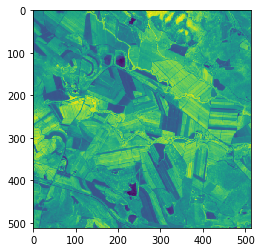

-0.04728132387706856
0.7744360902255639
0.0
1.0


In [189]:
ndvi = NDVI(TILE_X, TILE_Y,'2016-12-22')
# scaling of ndvi
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
print(min);print(max)

ndvi_scale = (ndvi - min)/(max-min) #scale to 0 to 1
print(np.nanmin(ndvi_scale));print(np.nanmax(ndvi_scale))


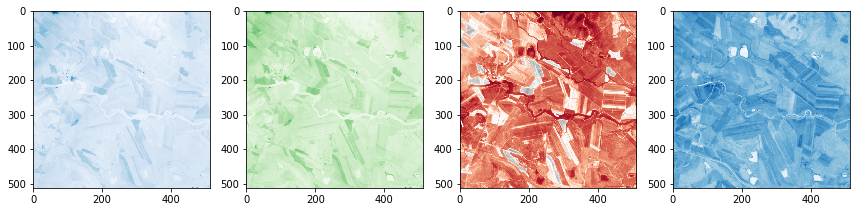

In [190]:

band_repre(TILE_X, TILE_Y,'2016-12-22')


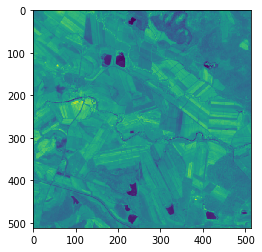

In [191]:
FCI(TILE_X, TILE_Y,'2016-12-22')

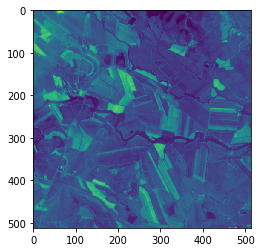

In [192]:

TCI(TILE_X, TILE_Y,'2016-12-22')

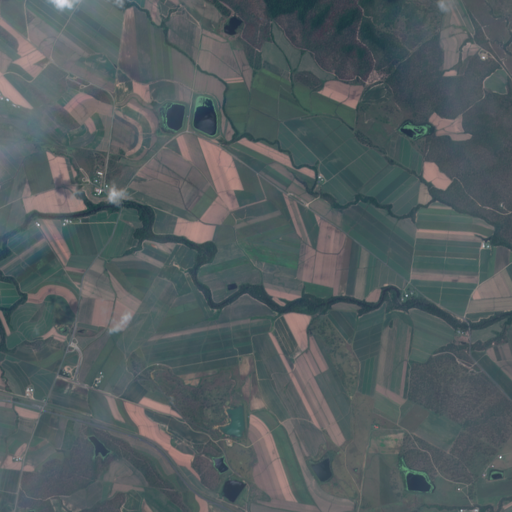

In [196]:
full = Image.open(get_cropped_image_paths(
    TILE_X, TILE_Y,date = '2016-12-22', band = 'TCI'))
full


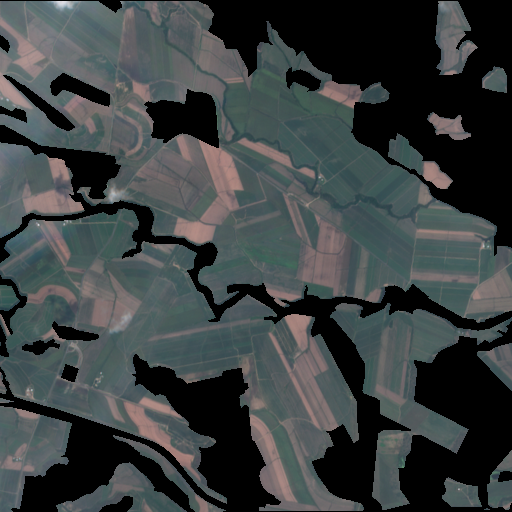

In [198]:
cropped = Image.open(get_cropped_image_paths(
    TILE_X, TILE_Y,date = '2016-12-22', band = 'TCI'))
cropped